영화 리뷰 분류에서 완전 연결된 신경망을 사용하여 벡터 입력을 어떻게 2개의 클래스로 분류하는지 보았다. 그램 2개 이상의 클래스가 있을 때는 어떻게 해야 할까요?

이번 예제에서 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만든다.

로이터 데이터셋 로드

In [1]:
from keras.datasets import reuters

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


IMDB 데이터셋처럼 num_words = 10000 매개변수는 데이터에서 가장 자주 등장하는 단어 1만개로 제한
여기에는 8982개의 훈련 샘플과 2246개의 테스트 샘플이 있다

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

IMDB리뷰처럼 각 샘플은 정수 리스트이다(단어 인덱스)

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

로이터 데이터셋 텍스트로 디코딩

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ''.join([reverse_word_index.get(i - 3,'?') for i in train_data[0]])

565248/550378 [==============================] - 0s 0us/step


샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수이다.

In [7]:
train_labels[10]

3

이전의 예제와 동일한 코드를 사용해 데이터를 벡터로 변환

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

In [9]:
x_train = vectorize_sequences(train_data) #훈련 데이터 벡터 변화
x_test = vectorize_sequences(test_data)  #테스트 데이터 벡터 변환

레이블을 벡터로 바꾸는 방법은 두 가지이다.
레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것이다.

In [22]:
def to_one_hot(labels, dimension=46):
  results =np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

케라스에는 이를 위한 내장 함수가 있다.

In [23]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보인다. 두 경우 모두 짧은 텍스트를 분류하는 것인데 여기에서는 새로운 제약 사항이 추가되었다. 출력 클래스의 개수가 2에서 46개로 늘어나서 출력 공간의 차원이 훨씬 커졌다.

이전에 사용했던 것처럼 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠

모델 정의하기

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

여기서 주목해야 할 점이 두 가지 있습니다

* 마지막 Dense 층의 크기가 46입니다. 각 입력 샘플에 대해서 46차원의 벡터를 
출력한다는 뜻입니다. 이 벡터의 각 원소(각 차원)는 각기 다른 출력 클래스가 
인코딩 된 것입니다.

* 마지막 층에 softmax 활성화 함수가 사용되었습니다. MNIST 예제에서 이런 방식을 보았습니다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉 46차원의 출력벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률입니다. 46개의 값을 모두 더하면 1이 됩니다

이런 문제에 사용할 최선의 손실 함수는 categorical_crossentropy 입니다. 이 함수는 두 확률 분포 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됩니다.

모델 컴파일하기

In [16]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 훈련 검증

훈련 데이터에서 1000개의 샘플을 따로 떼어서 검증 세트로 사용하겠습니다

In [24]:
#검증 세트 준비하기
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

이제 20번의 에포크로 모델을 훈련시킵니다.

In [25]:
#모델 훈련하기
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val,y_val))

Epoch 1/20
16/16 [==============================] - 15s 74ms/step - loss: 3.0942 - accuracy: 0.4147 - val_loss: 1.6672 - val_accuracy: 0.6510
Epoch 2/20
16/16 [==============================] - 1s 38ms/step - loss: 1.4595 - accuracy: 0.7030 - val_loss: 1.2592 - val_accuracy: 0.7140
Epoch 3/20
16/16 [==============================] - 1s 38ms/step - loss: 1.0391 - accuracy: 0.7761 - val_loss: 1.1084 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 0.8147 - accuracy: 0.8286 - val_loss: 1.0039 - val_accuracy: 0.7810
Epoch 5/20
16/16 [==============================] - 1s 37ms/step - loss: 0.6505 - accuracy: 0.8660 - val_loss: 0.9485 - val_accuracy: 0.7980
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.5213 - accuracy: 0.8907 - val_loss: 0.9177 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 1s 38ms/step - loss: 0.3961 - accuracy: 0.9165 - val_loss: 0.8948 - val_accuracy: 0.8160
Epoch 8/20
1

마지막으로 손실과 정확도 곡선을 그립니다

<function matplotlib.pyplot.show>

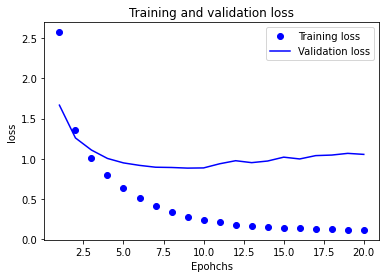

In [26]:
#훈련과 검증 손실 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epohchs')
plt.ylabel('loss')
plt.legend()

plt.show

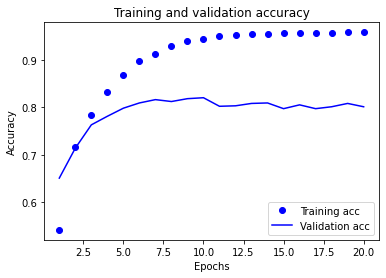

In [30]:
#훈련과 검증 정확도 그리기
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 아홉 번째 에포크 이후에 과대적합이 시작됩니다. 아홉 번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다.

In [31]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape =(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 57ms/step - loss: 3.2110 - accuracy: 0.4270 - val_loss: 1.7407 - val_accuracy: 0.6500
Epoch 2/9
16/16 [==============================] - 1s 38ms/step - loss: 1.4915 - accuracy: 0.7104 - val_loss: 1.3366 - val_accuracy: 0.7040
Epoch 3/9
16/16 [==============================] - 1s 38ms/step - loss: 1.0727 - accuracy: 0.7777 - val_loss: 1.1172 - val_accuracy: 0.7580
Epoch 4/9
16/16 [==============================] - 1s 37ms/step - loss: 0.8261 - accuracy: 0.8276 - val_loss: 1.0238 - val_accuracy: 0.7810
Epoch 5/9
16/16 [==============================] - 1s 39ms/step - loss: 0.6496 - accuracy: 0.8670 - val_loss: 0.9486 - val_accuracy: 0.8100
Epoch 6/9
16/16 [==============================] - 1s 38ms/step - loss: 0.5183 - accuracy: 0.8905 - val_loss: 0.9314 - val_accuracy: 0.8110
Epoch 7/9
16/16 [==============================] - 1s 38ms/step - loss: 0.4123 - accuracy: 0.9175 - val_loss: 0.9157 - val_accuracy: 0.8070
Epoch 8/9
16/16 [===

최종 결과는 다음과 같습니다.

In [32]:
results

[0.9850217700004578, 0.7871772050857544]

대략 78%의 정확도를 달성했습니다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 18% 정도를 달성합니다. 여기에 비하면 이 결과는 꽤 좋은 편입니다.

In [33]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18432769367764915

### 새로운 데이터에 대해 예측하기

모델 객체의 predict메서드는 46개의 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다.

In [34]:
#새로운 데이터에 대해 예측하기
predictions = model.predict(x_test)

predictions의 각 항목은 길이가 46인 벡터입니다.

In [35]:
predictions[0].shape

(46,)

이 벡터의 뭔소 합은 1입니다.

In [36]:
np.sum(predictions[0])

1.0000001

가장 큰 값이 예측 클래스가 됩니다. 즉 가장 확률이 높은 클래스입니다.

In [37]:
np.argmax(predictions[0])

3

### 레이블과 손실을 다루는 다른 방법
앞서 언급한 거서럼 레이블을 인코딩 하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다.

In [38]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. '모델을 처음부터 다시 훈련하기'에 사용된 손실함수 categorical_crossentropy는 레이블이 범주형 인코딩되어 있을 것이라고 기대합니다. 정수 레이블을 사용할 때는 sparse_categorical_crossentropy를 사용해야 합니다.

In [39]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 categorical_crossentropy와 동일합니다.

### 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원볻 훨씬 작은 중간층(예를들어 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [44]:
#정보 병목이 있는 모델
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 3.6733 - accuracy: 0.0338 - val_loss: 3.2446 - val_accuracy: 0.0240
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 3.0448 - accuracy: 0.0912 - val_loss: 2.4957 - val_accuracy: 0.2440
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 2.2956 - accuracy: 0.2383 - val_loss: 1.9837 - val_accuracy: 0.4000
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 1.8190 - accuracy: 0.4436 - val_loss: 1.6816 - val_accuracy: 0.6200
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 1.4503 - accuracy: 0.6489 - val_loss: 1.5111 - val_accuracy: 0.6280
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 1.2605 - accuracy: 0.6637 - val_loss: 1.4424 - val_accuracy: 0.6410
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 1.1921 - accuracy: 0.6722 - val_loss: 1.4129 - val_accuracy: 0.6640
Epoch 8/20
63

검증 정확도의 최고 값은 약 71%로 8% 정도 감소되었습니다. 이런 손실의 원인 대부분은 많은 정보(클래스 46개의 분할 초평면을 복원하기에 출분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했습니다.

### 정리
다음은 이 예제에서 배운 것들입니다.

* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense층의 크기는 N이어야 합니다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 학률 분포를 출력하기 위해 softmax 활성화 함수를 사용해야 합니다.
* 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화 합니다.
* 다중 분류에서 레이블을 다루는 두 가지 방법이 있습니다.
 * 레이블을 범주형 인코딩(원-핫 인코딩)으로 인코딩하고 categorical_crossentropy손실 함수를 사용합니다.
 * 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용합니다
* 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 합니다.